# Predicting Heart Disease

This is a binary classification project––with or without heart disease––with the overall goal of model accuracy. The dataset, [obtained from Kaggle](https://www.kaggle.com/danimal/heartdiseaseensembleclassifier?select=Heart_Disease_Data.csv), consists of 303 observations and [13 features](https://www.kaggle.com/iamkon/ml-models-performance-on-risk-prediction#Complete-attribute-documentation). Of the 303 observation, 160 are without heart disease and the remaining 143 have some degree of heart disease. The study from which the data are drawn distinguishes between not having heart disease (0, in the 'pred_attribute' column) and 4 degrees of having the disease (1, 2, 3, 4). [Experiments with this dataset have concentrated on simply distinguishing between having and not having the disease](https://www.kaggle.com/iamkon/ml-models-performance-on-risk-prediction), and I have done the same here.

The dataset is already fairly clean, which gave me an opportunity to spend more time comparing the performance of a variety of models––a logistic regression model, SVCs, a KNN model, decision trees and Random Forests, and AdaBoost and XGBoost––as well as to try putting together an ensemble of my own.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns
import pydotplus
import collections
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from xgboost import XGBClassifier

%matplotlib inline

In [2]:
sns.set_style('whitegrid')
sns.set_palette("mako")

## Exploratory Data Analysis

In [3]:
df = pd.read_csv('../data/Heart_Disease_Data.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slop,ca,thal,pred_attribute
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


In [4]:
df.shape

(303, 14)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             303 non-null    int64  
 1   sex             303 non-null    int64  
 2   cp              303 non-null    int64  
 3   trestbps        303 non-null    int64  
 4   chol            303 non-null    int64  
 5   fbs             303 non-null    int64  
 6   restecg         303 non-null    int64  
 7   thalach         303 non-null    int64  
 8   exang           303 non-null    int64  
 9   oldpeak         303 non-null    float64
 10  slop            303 non-null    int64  
 11  ca              303 non-null    object 
 12  thal            303 non-null    object 
 13  pred_attribute  303 non-null    int64  
dtypes: float64(1), int64(11), object(2)
memory usage: 33.3+ KB


In [6]:
df['ca'].value_counts()

0    176
1     65
2     38
3     20
?      4
Name: ca, dtype: int64

In [7]:
df['thal'].value_counts()

3    166
7    117
6     18
?      2
Name: thal, dtype: int64

In [8]:
df['ca'].loc[df['ca']=='?'] = None
df['thal'].loc[df['thal']=='?'] = None

/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [9]:
df = df.dropna(axis=0)
df['ca'] = df['ca'].astype('int')
df['thal'] = df['thal'].astype('int')
X = df.drop('pred_attribute', axis=1)
y = df['pred_attribute']

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             297 non-null    int64  
 1   sex             297 non-null    int64  
 2   cp              297 non-null    int64  
 3   trestbps        297 non-null    int64  
 4   chol            297 non-null    int64  
 5   fbs             297 non-null    int64  
 6   restecg         297 non-null    int64  
 7   thalach         297 non-null    int64  
 8   exang           297 non-null    int64  
 9   oldpeak         297 non-null    float64
 10  slop            297 non-null    int64  
 11  ca              297 non-null    int64  
 12  thal            297 non-null    int64  
 13  pred_attribute  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 34.8 KB


In [73]:
df.to_csv('../data/app_data.csv')

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'sex'}>,
        <AxesSubplot:title={'center':'cp'}>,
        <AxesSubplot:title={'center':'trestbps'}>],
       [<AxesSubplot:title={'center':'chol'}>,
        <AxesSubplot:title={'center':'fbs'}>,
        <AxesSubplot:title={'center':'restecg'}>,
        <AxesSubplot:title={'center':'thalach'}>],
       [<AxesSubplot:title={'center':'exang'}>,
        <AxesSubplot:title={'center':'oldpeak'}>,
        <AxesSubplot:title={'center':'slop'}>,
        <AxesSubplot:title={'center':'ca'}>],
       [<AxesSubplot:title={'center':'thal'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

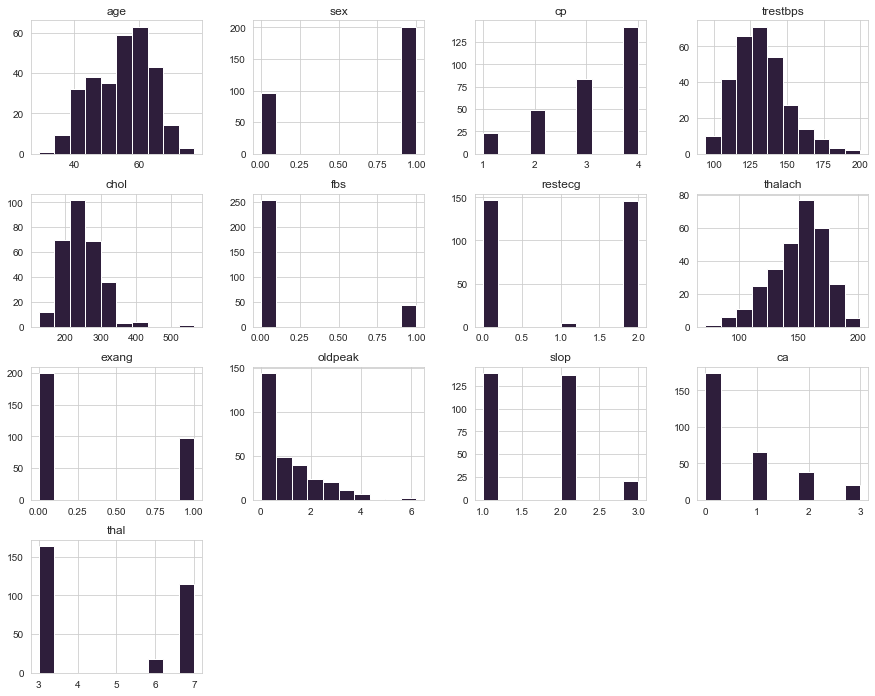

In [10]:
X.hist(figsize=(15, 12))

'ca', 'cp', 'exang', 'fbs', 'restecg', 'sex', 'slop', 'thal' ALL appear to be categorical. My continuous variables have very different ranges––\[0, 6\] for 'oldpeak', but \[100, 200\] for 'trestbps'––so I'll probably standardize them to be on the safe side.

Below, I'm casting all my labels greater than 0 as 1 because, for the sake of this project, 1, 2, 3, 4 are all degrees of heart disease. Simply recasting them all as 1.

In [11]:
y[y>0]=1

/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
y.value_counts()

0    160
1    137
Name: pred_attribute, dtype: int64

And with that, it's time to create train and test sets, as well as to try a first set of models to see how they perform out of the box.

## Very Early Baseline Models

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=123)

In [14]:
baseline_classifiers = {'LogReg': LogisticRegression(random_state=42),
                        'KNN': KNeighborsClassifier(n_neighbors=3),
                        'SVC': SVC(gamma='auto', random_state=42),
                        'DT': DecisionTreeClassifier(random_state=42),
                        'RF': RandomForestClassifier(random_state=42),
                        'Ada': AdaBoostClassifier(DecisionTreeClassifier(random_state=42), random_state=42), 
                        'XGB': XGBClassifier(random_state=42)}

baseline_acc = {}
baseline_recall = {}
for clf in baseline_classifiers:
    name = clf
    clf = baseline_classifiers[clf]
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    acc = accuracy_score(y_test, preds)
    recall = recall_score(y_test, preds)
    baseline_acc[name] = acc
    baseline_recall[name] = recall
    
print('Recall:')
print(pd.Series(baseline_recall).sort_values(ascending=False))
print('')
print('Accuracy:')
print(pd.Series(baseline_acc).sort_values(ascending=False))

/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Recall:
RF        0.857143
LogReg    0.828571
XGB       0.800000
Ada       0.800000
DT        0.800000
KNN       0.514286
SVC       0.028571
dtype: float64

Accuracy:
LogReg    0.853333
RF        0.840000
XGB       0.813333
DT        0.773333
Ada       0.746667
KNN       0.586667
SVC       0.546667
dtype: float64


Not bad at all, with a random forest and logistic regression leading the pack at .83 and .86 recall on test data, respectively. Looking at accuracy scores, however, shows that KNN and (radial basis function) SVC don't do much better than random guessing at this point.

Before I move onto tuning models, I want to try tuning my data first. Who said, "Good models don't come from good models; good models come from good data"?

## Feature Engineering

I start by looking for highly correlated features and using a Random Forest to gauge feature importance.

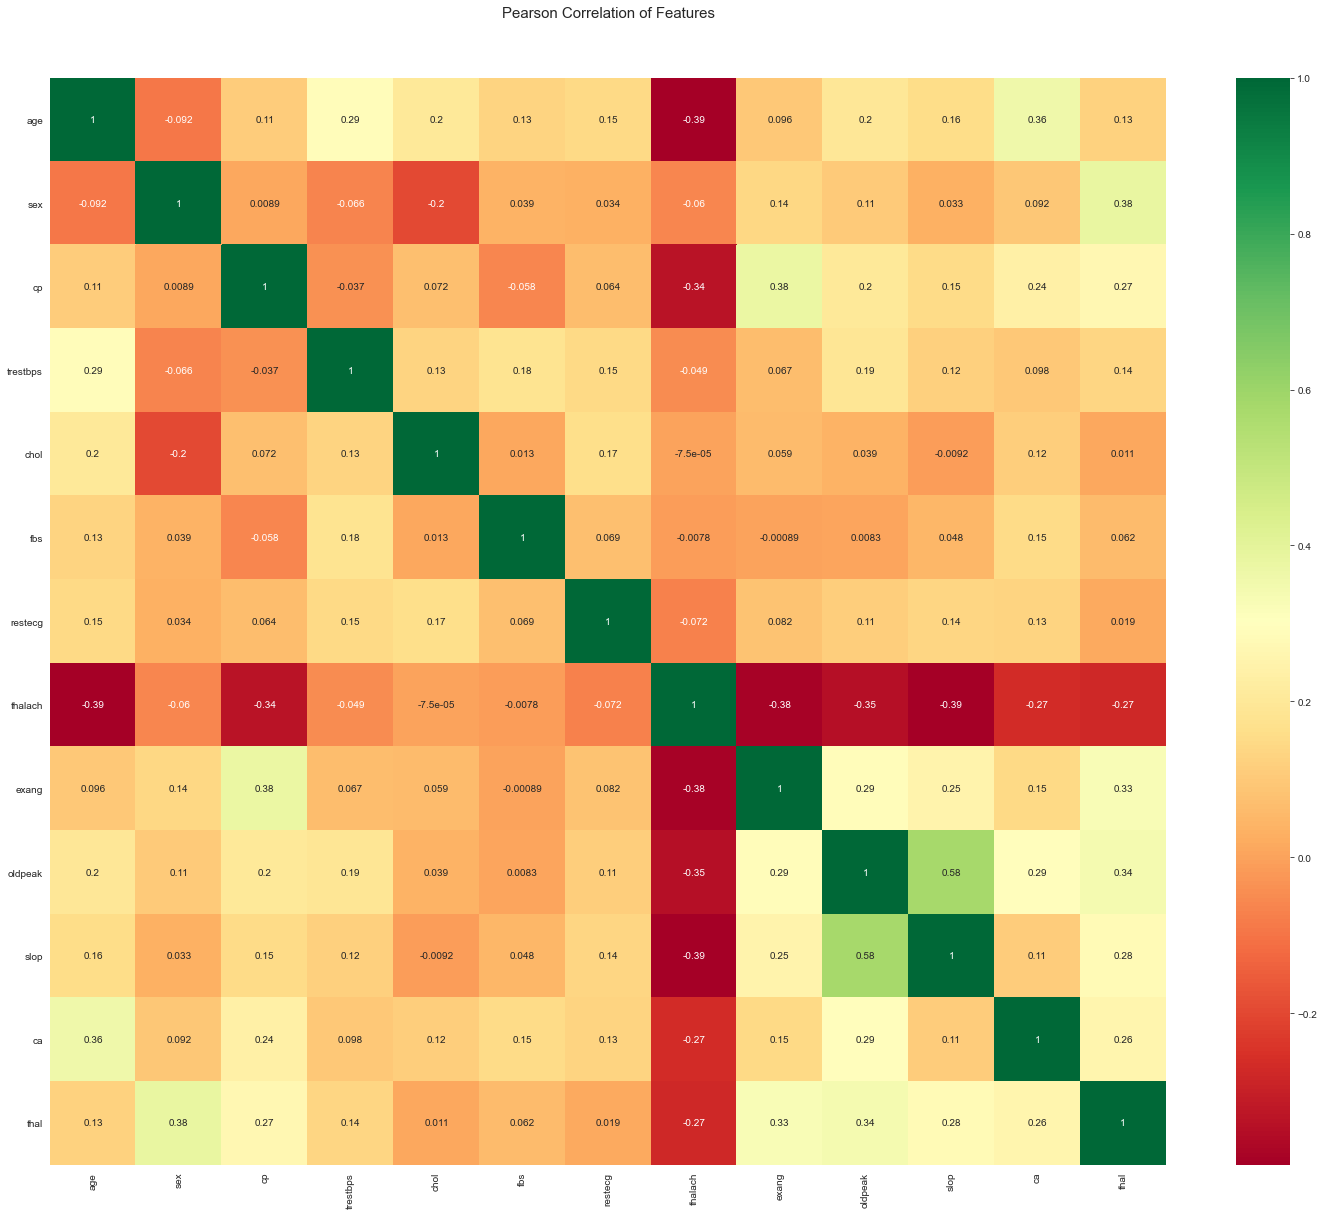

In [15]:
sns.heatmap(X.corr(),annot=True,cmap='RdYlGn')
fig=plt.gcf()
fig.set_size_inches(25,20)
#plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
plt.show()

In [16]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

thalach     0.128969
cp          0.122558
thal        0.112145
ca          0.106617
oldpeak     0.104328
age         0.091347
chol        0.083361
trestbps    0.080489
exang       0.064376
slop        0.046107
sex         0.027416
restecg     0.024662
fbs         0.007625
dtype: float64

According to this model, 'thalach' appears to be the most import feature for this dataset, but looking at the heatmap above, it's also the most correlated with the most other features. If I had to pick just one feature, I'd choose this one, but for the sake of choosing multiple features, I'm going to exclude it; none of my other features are so highly correlated with each other. I take instead 'cp' through 'trestbps' (cutoff chosen somewhat arbitrarily).

In [17]:
new_colspace = ['oldpeak', 'chol', 'age', 'trestbps', 'ca', 'cp', 'thal']
X_train = X_train[new_colspace]
X_test = X_test[new_colspace]

And I standardize my predictors.

In [18]:
ss = StandardScaler()
X_train = pd.DataFrame(ss.fit_transform(X_train), columns=new_colspace)
X_test = pd.DataFrame(ss.transform(X_test), columns=new_colspace)

array([[<AxesSubplot:title={'center':'oldpeak'}>,
        <AxesSubplot:title={'center':'chol'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'trestbps'}>,
        <AxesSubplot:title={'center':'ca'}>,
        <AxesSubplot:title={'center':'cp'}>],
       [<AxesSubplot:title={'center':'thal'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

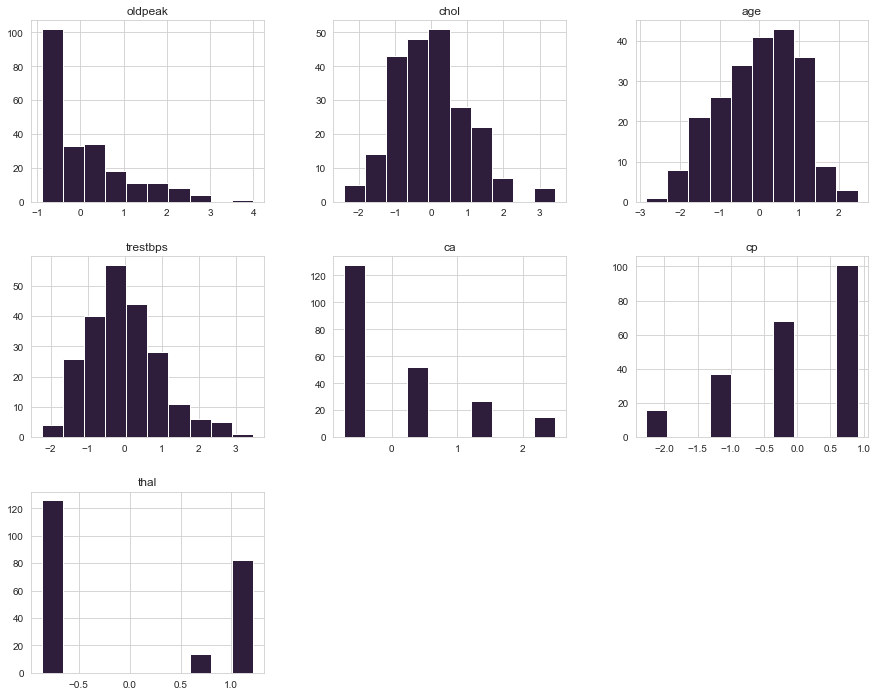

In [19]:
X_train.hist(figsize=(15, 12))

Much better. My features are now all spread, more or less, between \[-2, 2\].

In [20]:
X_train.to_pickle('../data/preprocessed/X_train.pkl')
X_test.to_pickle('../data/preprocessed/X_test.pkl')

with open('../data/preprocessed/y_train.pkl', 'wb') as fp:
    pickle.dump(y_train, fp)
    
with open('../data/preprocessed/y_test.pkl', 'wb') as fp:
    pickle.dump(y_test, fp)

In [53]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import ScalarMappable

In [44]:
sns.set_style('whitegrid')
sns.set_palette('rocket')

In [70]:
option1='trestbps'
option2='age'
option3='chol'

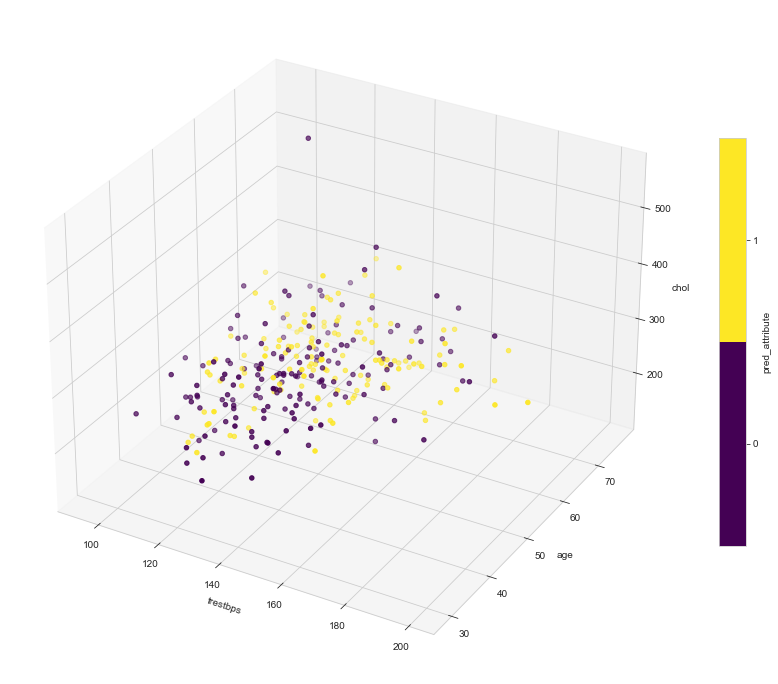

In [79]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111,projection='3d')
sctt=ax.scatter3D(df[option1], df[option2], df[option3], c=df['pred_attribute'], cmap='viridis', marker='o')
ax.set_xlabel(option1)
ax.set_ylabel(option2)
ax.set_zlabel(option3)
fig.colorbar(sctt, ax = ax, shrink = .5, aspect = 15, ticks=[0,1], boundaries=[-.5,.5,1.5], label='pred_attribute')
plt.show()

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             297 non-null    int64  
 1   sex             297 non-null    int64  
 2   cp              297 non-null    int64  
 3   trestbps        297 non-null    int64  
 4   chol            297 non-null    int64  
 5   fbs             297 non-null    int64  
 6   restecg         297 non-null    int64  
 7   thalach         297 non-null    int64  
 8   exang           297 non-null    int64  
 9   oldpeak         297 non-null    float64
 10  slop            297 non-null    int64  
 11  ca              297 non-null    int64  
 12  thal            297 non-null    int64  
 13  pred_attribute  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 34.8 KB
